# Installation

In [1]:
# !pip install src/

# Setup


In [2]:
import multipers as mp
from multipers import noisy_annulus
import gudhi as gd
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import numpy as np

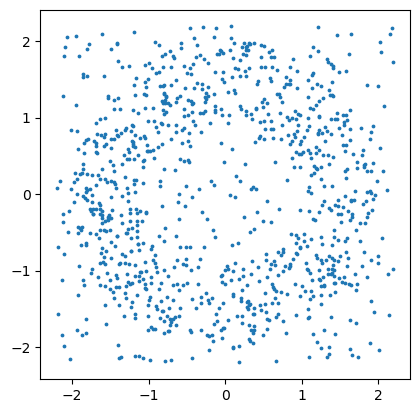

In [3]:
npts = 1000
noutliers = (int)(npts * 0.4)
npts -= noutliers
np.random.seed(100)
X = noisy_annulus(n1=npts, n2=noutliers)
ax = plt.gca();ax.set_aspect('equal')
plt.scatter(X[:,0], X[:,1],s=3)

## Rips + codensity

In [4]:
simplextree = gd.RipsComplex(points = X, sparse=0.3).create_simplex_tree()
simplextree = mp.SimplexTreeMulti(simplextree, num_parameters = 2)
density = KernelDensity(bandwidth=0.25).fit(X).score_samples(X)
simplextree.fill_lowerstar(-density, parameter=1)
simplextree.collapse_edges(num=100, progress=1, max_dimension=1)

Removing edges:   7%|▋         | 7/100 [00:00<00:05, 16.29it/s]


## Turns the filtrations of the simplextree to coordinate in a grid

In [5]:
grid_shape = [50,50]
st = mp.SimplexTreeMulti(simplextree) # Copy (for later) as grid_squeeze change filtration values
filtration_grid = st.get_filtration_grid(resolution=grid_shape, grid_strategy="regular")
st.grid_squeeze(filtration_grid=filtration_grid, coordinate_values=True) # regular can be replaced by quantiles

In [6]:
# There are way less filtration values -> edge collapse
st.collapse_edges(full=True, progress=1, max_dimension=2)
st.num_simplices()

Removing edges:  14%|█▍        | 14/100 [00:00<00:01, 58.12it/s]


6753

In [7]:
## The rank inv assumes that st is a coordinate simplextree
rank_tensor = mp.rank_invariant2d(simplextree=st, degree=1, grid_shape=grid_shape) ## Only works for 2-parameter simplextrees

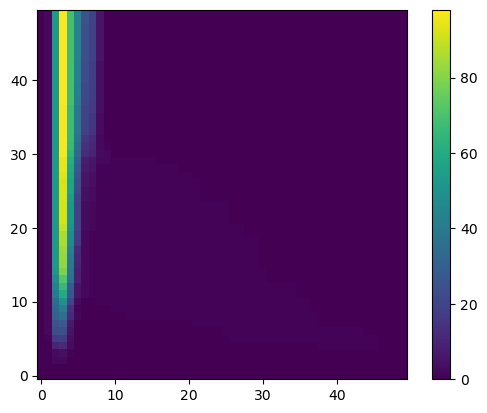

In [8]:
hilbert = mp.hilbert2d(simplextree=st, degree=1, grid_shape=grid_shape) ## Only works for 2-parameter simplextrees
plt.imshow(hilbert.T, origin="lower")
plt.colorbar()

## Rectangle decomposition, signed measure

In [9]:
from signed_betti import signed_betti, rank_decomposition_by_rectangles, tensor_to_rectangle, betti_matrix2signed_measure

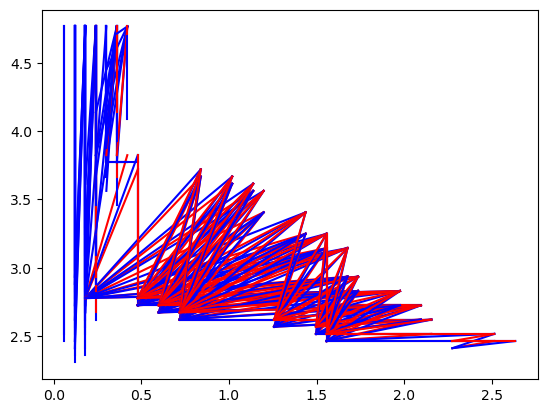

In [10]:
rectangle_decompo = rank_decomposition_by_rectangles(rank_tensor)
rectangle_decompo = tensor_to_rectangle(rectangle_decompo, plot=True, grid_conversion=filtration_grid)

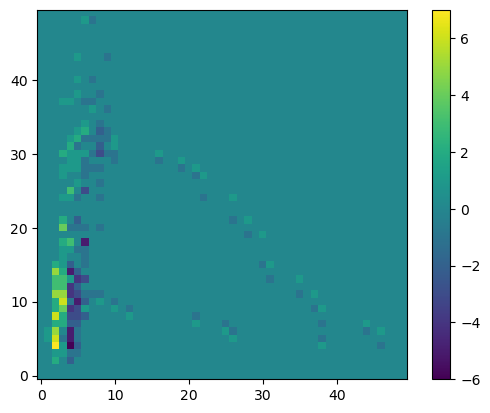

In [11]:
betti = signed_betti(hilbert_function=hilbert)
signed_measure = betti_matrix2signed_measure(betti)
plt.imshow(betti.T, origin="lower")
plt.colorbar()

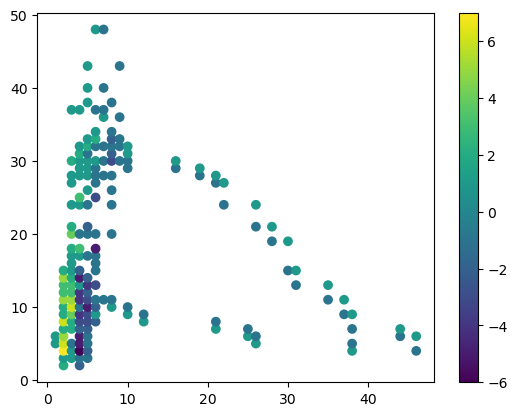

In [12]:
plt.figure()
plt.scatter(signed_measure[:,0], signed_measure[:,1], c=signed_measure[:,2])
plt.colorbar()

## Pipelines test

In [13]:
%load_ext autoreload
%autoreload 2
from wrappers import *


In [14]:
grid_shape = np.asarray([100,100])

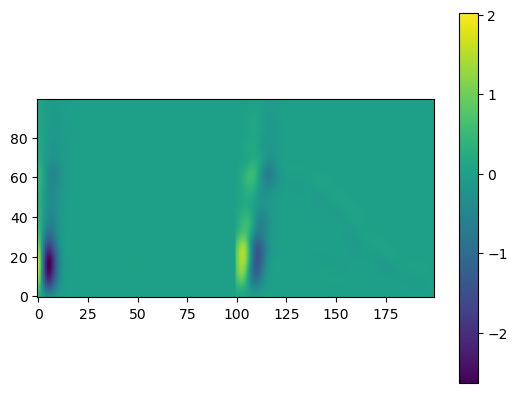

In [15]:
cst = mp.SimplexTreeMulti(simplextree)
filtration_grid = cst.get_filtration_grid(resolution=grid_shape)
ToSM = SimplexTree2SignedMeasure(degrees = [0,1], filtration_grid=filtration_grid, num_collapses=100, max_dimension=2)
signed_measure = ToSM.fit_transform([cst])
filtration_grid = ToSM.filtration_grid
sm_vect = SignedMeasure2img(filtration_grid=filtration_grid, bandwidth=.1).fit_transform(signed_measure)

for img in sm_vect:
    plt.imshow(img.T, origin="lower")
    plt.colorbar()
    plt.show()